### 'Distributed workflow for each taxa'

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy
from itertools import repeat
import functools

In [2]:
env_path = "../../.env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

In [3]:
aol_password = env['ARCGIS_GRETA_PASS']
aol_username = env['ARCGIS_GRETA_USER']

In [4]:
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")

In [166]:
### gadm tables
## Original scott table (https://eowilson.maps.arcgis.com/home/item.html?id=ba1e71b5d83548808ee02d1108221cae)
gadm= gpd.read_file('zip:///Users/tamarahuete/Documents/HALF_EARTH/WDPA_FILTERED_20210615_FILTERED_nomarine_with_oecm_wdpa.zip')
gadm.rename(columns={'AREA_KM':'AREA_KM2'},inplace=True)

In [167]:
### Use here simple gadm0 
dff = gadm[['NAME','MOL_ID','AREA_KM2']] ## remove geometry here because it is the non-simplified table
dff['reptiles']=np.nan
dff['amphibians']=np.nan
dff['mammals']=np.nan
dff['birds']=np.nan

paths = {'amphibians':'../../HALF_EARTH/wdpa_amphibians_sample_20211003_nozeros.zip',
         'birds':'../../HALF_EARTH/wdpa_birds_final_20211003.csv',
         'mammals':'../../HALF_EARTH/wdpa_mammals_final_20211003.csv',
         'reptiles':'../../HALF_EARTH/wdpa_reptiles_final_20211003.zip'}

### Ids of lookup tables for each taxa in ArcGIS online
lookups = {'amphibians':'a641a4cd269345dea93b8bcb1cb66676',
         'birds':'4d8698734b654bb9bb7a61d9af314c76',
         'mammals':'84d3c71caf97479d85f620a4ee217d68',
         'reptiles':'b720e84869624e5482b25338b27a54f2'}

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying t

In [7]:
def getHTfromId(item_id):
    item = gis.content.get(item_id)
    flayer = item.tables[0]
    sdf = flayer.query().sdf
    return sdf

In [8]:
def breaks(n):
    step = int(np.floor(217486/n))
    ls = list(np.arange(0,217486,step=step))
    ls.append(217486)
    return ls

In [9]:
def first_last(n, step):
    values = breaks(n)
    return [values[step-1],values[step]]

In [10]:
def format_aoi(taxa,n,step):
    save_steps= np.arange(1,217486,step=5000)
    ### Loop over each set of data and add all results to one dictionary that will be a text field in the Feature Service

    df = pd.read_csv(paths[taxa])
    col_name = [col for col in df.columns if col in ['amphibians','birds','presence','reptiles']]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)

    ### Get species area against global species range:
    lookup = getHTfromId(lookups[taxa])
    df = df.merge(lookup[['SliceNumber','range_area_km2']], how='left',on = 'SliceNumber')
    df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
    df.loc[df['per_global']> 100,'per_global'] = 100 ### make max presence 100%
    
    ### Get species area against aoi area:
    df = df.merge(gadm[['MOL_ID','AREA_KM2']])
    df['per_aoi'] = round(df['SUM']/df['AREA_KM2']*100,2)
    df.loc[df['per_aoi']> 100,'per_aoi'] = 100 ### make max presence 100%
    
    ## Get split range
    first = first_last(n, step)[0]
    last = first_last(n, step)[1]
    print(f'range {first}-{last}, total = {last-first}')
    
    for i in list(dff.MOL_ID[first:last].values): 
        species = []
        for j in df[(df.MOL_ID== i)].SliceNumber.unique():
            sp_dict = {'SliceNumber':int(df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0]),
                       'per_global':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_global.values[0],
                       'per_aoi':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_aoi.values[0]
                      }
            species.append(sp_dict)
        dff.loc[dff['MOL_ID']==i,taxa] =json.dumps(species)
        print(f'finished MOL_ID ={i}')
        if i in save_steps:
            pd.set_option('display.max_colwidth',None)
            dff.to_csv(f'../../HALF_EARTH/wdpa_precalc_biodiv_range_{taxa}_{step}.csv',index=False)
    dff.to_csv(f'../../HALF_EARTH/wdpa_precalc_biodiv_range_{taxa}_{step}.csv',index=False)
    return dff


### Add pandarallel to distribute work locally
Pandarallel works on apply functions. The code needs to be formatted to have apply instead of for loops. This requires creating some extra functions. [Example of how to use](https://towardsdatascience.com/pandaral-lel-a-simple-and-efficient-tool-to-parallelize-your-pandas-operations-on-all-your-cpus-bb5ff2a409ae)

In [11]:
from pandarallel import pandarallel

In [12]:
pandarallel.initialize(progress_bar = True) 

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [107]:
def create_dict(df,molid,species_j):
    sp_dict = {'SliceNumber':int(df[(df['MOL_ID']== int(molid)) & (df.SliceNumber==int(species_j))].SliceNumber.values[0]),
                   'per_global':df[(df.MOL_ID==molid) & (df.SliceNumber==species_j)].per_global.values[0],
                   'per_aoi':df[(df.MOL_ID== molid) & (df.SliceNumber==species_j)].per_aoi.values[0]
                  }
    return sp_dict

In [120]:
def getSliceNumbers(df,molid):
    return list(df[(df.MOL_ID== molid)].SliceNumber.unique())

In [122]:
def format_array(df,molid):
    uniqueSlices = getSliceNumbers(df,molid)
    species = list(map(functools.partial(create_dict,df),repeat(molid),uniqueSlices))
    return json.dumps(species)

In [132]:
def format_aoi_pandarallel(taxa,n,step):
    save_steps= np.arange(1,217486,step=5000)
    ### Loop over each set of data and add all results to one dictionary that will be a text field in the Feature Service

    df = pd.read_csv(paths[taxa])
    col_name = [col for col in df.columns if col in ['amphibians','birds','presence','reptiles']]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)

    ### Get species area against global species range:
    lookup = getHTfromId(lookups[taxa])
    df = df.merge(lookup[['SliceNumber','range_area_km2']], how='left',on = 'SliceNumber')
    df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
    df.loc[df['per_global']> 100,'per_global'] = 100 ### make max presence 100%
    
    ### Get species area against aoi area:
    df = df.merge(gadm[['MOL_ID','AREA_KM2']])
    df['per_aoi'] = round(df['SUM']/df['AREA_KM2']*100,2)
    df.loc[df['per_aoi']> 100,'per_aoi'] = 100 ### make max presence 100%
    
    ### Map over mol ids
    ## Get split range
    first = first_last(n, step)[0]
    last = first_last(n, step)[1]
    subset = dff[dff['MOL_ID'].isin(dff.MOL_ID[first:last].values)]
    
    subset[taxa] = subset.parallel_apply(lambda x: print(x['MOL_ID']) or format_array(df,x['MOL_ID']),axis=1)
    
    return subset

### Test pandarallel paralelization

In [29]:
subset_map = dff[0:5]
subset_loop=dff[0:5]
subset_par=dff[0:5]

In [123]:
%%time ### for loop
for i in list(subset_loop.MOL_ID.values): 
    species = []
    for j in df[(df.MOL_ID== i)].SliceNumber.unique():
        sp_dict = {'SliceNumber':int(df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0]),
                   'per_global':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_global.values[0],
                   'per_aoi':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_aoi.values[0]
                  }
        species.append(sp_dict)
    subset_loop.loc[subset_loop['MOL_ID']==i,taxa] =json.dumps(species)

CPU times: user 7min 21s, sys: 55.8 s, total: 8min 17s
Wall time: 9min 13s


In [180]:
%%time ### Change for loop for map
subset_map[taxa] = subset_map.apply(lambda x:print(x['MOL_ID']) or format_array(x['MOL_ID'] in list(dff.MOL_ID[0:2].values)),axis=1)

1
2
3
4
5
CPU times: user 30.7 s, sys: 3.51 s, total: 34.2 s
Wall time: 36.1 s


/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
taxa = 'mammals'
test = pd.read_csv(paths[taxa])

In [115]:
%%time 
### Add pandarallel to map
subset_par[taxa] = subset_par.parallel_apply(lambda x: format_array(x['MOL_ID'],df),axis=1)

CPU times: user 162 ms, sys: 71.2 ms, total: 234 ms
Wall time: 563 ms


/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [139]:
compare = pd.DataFrame(data={'ids':[5,10,20,30],'map':[95,170,282,616],'loop':[90,163,291,553], 'parallel':[0,0,0,204]})

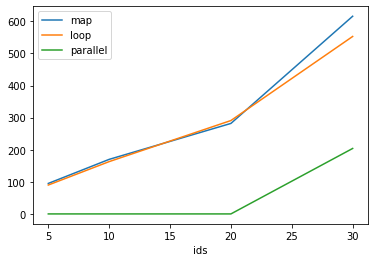

In [140]:
compare.plot(x='ids')

### Run with parallelization

In [ ]:
%%time
output = format_aoi_pandarallel(taxa = 'mammals',n = 4,step =4)

In [ ]:
### There are some WDPAs that are missing MOLID (???)

In [141]:
taxa= 'mammals'
step= 4

In [179]:
missing_index = [186892, 207130, 217482, 217483, 217484, 217485]

In [186]:
missing_molid= list(dff.loc[dff.index.isin(missing_index),'MOL_ID'])

In [189]:
df = pd.read_csv(paths[taxa])
col_name = [col for col in df.columns if col in ['amphibians','birds','presence','reptiles']]
df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)

### Get species area against global species range:
lookup = getHTfromId(lookups[taxa])
df = df.merge(lookup[['SliceNumber','range_area_km2']], how='left',on = 'SliceNumber')
df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
df.loc[df['per_global']> 100,'per_global'] = 100 ### make max presence 100%

### Get species area against aoi area:
df = df.merge(gadm[['MOL_ID','AREA_KM2']])
df['per_aoi'] = round(df['SUM']/df['AREA_KM2']*100,2)
df.loc[df['per_aoi']> 100,'per_aoi'] = 100 ### make max presence 100%

for i in missing_molid: 
    species = []
    for j in df[(df.MOL_ID== i)].SliceNumber.unique():
        sp_dict = {'SliceNumber':int(df[(df.MOL_ID== i) & (df.SliceNumber==j)].SliceNumber.values[0]),
                   'per_global':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_global.values[0],
                   'per_aoi':df[(df.MOL_ID== i) & (df.SliceNumber==j)].per_aoi.values[0]
                  }
        species.append(sp_dict)
    dff.loc[dff['MOL_ID']==i,taxa] =json.dumps(species)
    print(f'finished MOL_ID ={i}')

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


finished MOL_ID =186893
finished MOL_ID =207131
finished MOL_ID =217483
finished MOL_ID =217484
finished MOL_ID =217485
finished MOL_ID =217486


In [164]:
output.dropna(subset=['MOL_ID'],inplace=True)

/Users/tamarahuete/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [192]:
output.append(dff[dff['MOL_ID'].isin(missing_molid)]).to_csv(f'../../HALF_EARTH/wdpa_precalc_biodiv_range_{taxa}_{step}.csv',index=False)